In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
#データの読み込み
df = pd.read_csv("CD3D_100-150℃_0.2-1.6mm_0.4-0.9V")

In [3]:
#COMSOLの解析結果
df1 = df.rename(columns={'V[V]': 'V','T_cell[℃]':'T','W_ch[mm]':'W'})
df1

,Unnamed: 0,x座標,y座標,z座標,V,T,W,i[A/m^2]
0,64319,0.000676,0.006895,0.000583,0.45,100.0,0.4,17184.547872
1,61498,0.000644,0.003244,0.000617,0.45,100.0,0.4,17315.513750
2,27871,0.000292,0.004137,0.000550,0.45,100.0,0.4,16698.183385
3,17751,0.000188,0.007300,0.000650,0.45,100.0,0.4,16967.409909
4,58631,0.000612,0.000197,0.000550,0.45,100.0,0.4,17538.277473
...,...,...,...,...,...,...,...,...
5909995,29805,0.000790,0.010001,0.000342,0.90,150.0,1.6,1377.190853
5909996,48973,0.001290,0.008375,0.000334,0.90,150.0,1.6,1428.051138
5909997,44590,0.001170,0.005122,0.000350,0.90,150.0,1.6,1416.399668
5909998,16152,0.000430,0.010638,0.000317,0.90,150.0,1.6,1625.205923


In [4]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import train_test_split

#予測ターゲットの格納（目的変数）
target_df = df1[["i[A/m^2]"]]
#特徴量の格納（説明変数）
train_df = df1.iloc[:,1:7]

#モデル学習のための、訓練データとテストデータを7:3で分割
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.3)

fold 0 MSE: 117353.74990412135
fold 1 MSE: 128440.19638795158
fold 2 MSE: 120286.65024721436
fold 3 MSE: 123104.09970377976
fold 4 MSE: 124029.9569873653
CV score: 122642.93064608646
[12274.15883085 15434.75378221 26121.2696779  ...  2239.26982378
 11780.46074634 17318.40672219]


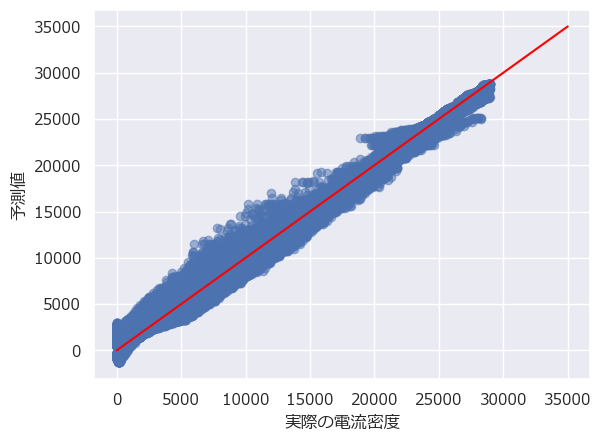

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

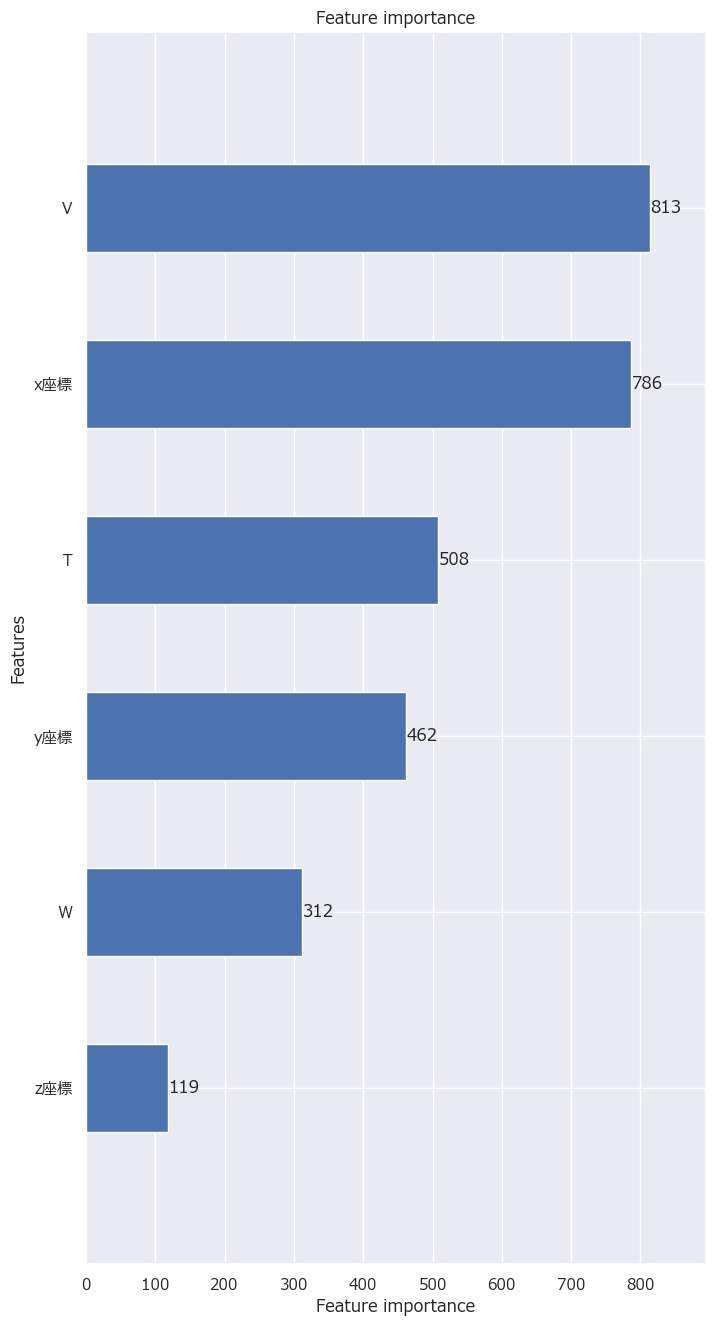

In [5]:
#モデル学習のための、KFoldで交差検証法

FOLD = 5
NUM_ROUND = 100
VERBOSITY = -1

params = {
    'objective': 'regression',
    'verbosity': -1,
}

valid_scores = []
models = []

kf = KFold(n_splits=FOLD, shuffle=True, random_state=1)

for fold, (train_index, valid_index) in enumerate(kf.split(X_train)):    
    X_test_train_cv ,y_train_cv = X_train.iloc[train_index], y_train.iloc[train_index]
    X_valid_cv ,y_valid_cv = X_train.iloc[valid_index], y_train.iloc[valid_index]
    lgb_train = lgb.Dataset(X_test_train_cv, y_train_cv)
    lgb_eval = lgb.Dataset(X_valid_cv, y_valid_cv)
    
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=NUM_ROUND,
        #verbosity =VERBOSITY
    )
    
    y_valid_pred = model.predict(X_valid_cv)
    score = mean_squared_error(y_valid_cv, y_valid_pred)
    print(f'fold {fold} MSE: {score}')
    valid_scores.append(score)

    models.append(model)

cv_score = np.mean(valid_scores) #平均
print(f'CV score: {cv_score}')

pred = model.predict(X_test)
print(pred)
    
#散布図で予測の精度を描写
sns.set(font=['Meiryo','Yu Gothic'])
plt.scatter(y_test, pred, alpha = 0.5)
plt.plot(np.linspace(0, 35000), np.linspace(0, 35000), "red")
plt.xlabel('実際の電流密度')
plt.ylabel('予測値')
plt.show()

# 性能向上に寄与する度合いで重要度をプロット
lgb.plot_importance(model, height = 0.5, figsize = (8,16))

In [6]:
df2 = df1[(df1["V"]==0.4) & (df1["T"]==100)&(df1["W"]==0.4)]
df2

,Unnamed: 0,x座標,y座標,z座標,V,T,W,i[A/m^2]
30000,51186,0.000540,0.009653,0.000576,0.4,100.0,0.4,19340.084177
30001,72603,0.000764,0.008947,0.000617,0.4,100.0,0.4,19815.735386
30002,49331,0.000516,0.002561,0.000550,0.4,100.0,0.4,19809.636295
30003,25295,0.000268,0.008738,0.000617,0.4,100.0,0.4,19446.807653
30004,40548,0.000428,0.008865,0.000617,0.4,100.0,0.4,19076.297898
...,...,...,...,...,...,...,...,...
59995,27009,0.000284,0.005834,0.000583,0.4,100.0,0.4,19571.328275
59996,69967,0.000732,0.001970,0.000650,0.4,100.0,0.4,20571.871583
59997,20835,0.000220,0.006895,0.000583,0.4,100.0,0.4,19799.010613
59998,73916,0.000772,0.001182,0.000650,0.4,100.0,0.4,20666.798777


In [7]:
df3 = model.predict(df2.iloc[:,1:7])

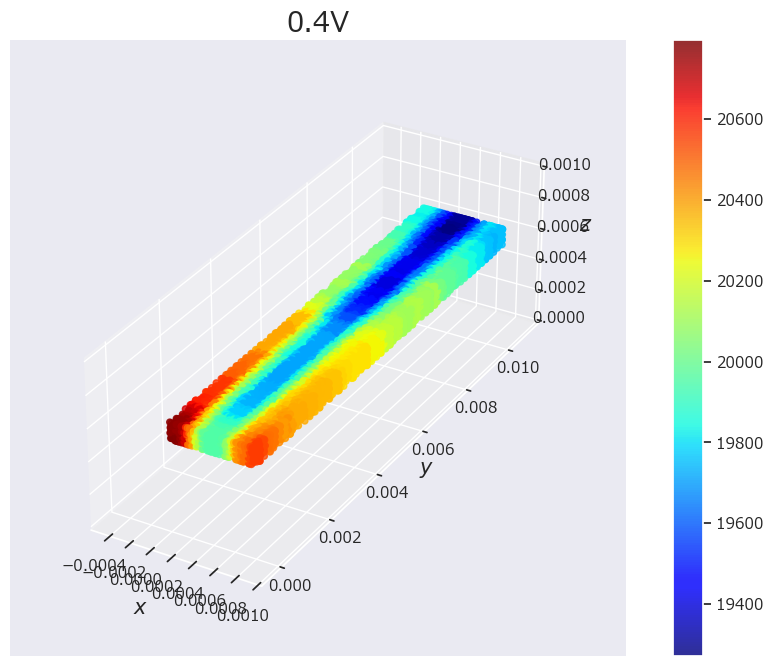

In [8]:
fig1 = plt.figure(figsize=(12, 8))
ax1 = fig1.add_subplot(111, projection='3d')

sc1 = ax1.scatter(df2['x座標'], df2['y座標'],df2['z座標'], c=df3, cmap='jet', alpha=0.8)
plt.colorbar(sc1)

ax1.set_title("0.4V", fontsize=20)
ax1.set_xlabel('$x$', fontsize=15)
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_zlabel('$z$', fontsize=15)
ax1.set_box_aspect((1,3,1))

ax1.set_xlim(-0.00055,0.001)
#ax1.set_ylim(0,0.015)
ax1.set_zlim(0,0.001)

#plt.savefig('PEM_CD_COMSOL.png')
plt.show()

In [10]:
df2b = df1[(df1["V"]==0.4) & (df1["T"]==100)&(df1["W"]==1.6)]
df4 = df2b.replace({'V': {0.4: 0.82}}).replace({'T': {100: 145}})
df4

,Unnamed: 0,x座標,y座標,z座標,V,T,W,i[A/m^2]
690000,66071,0.00173,0.004334,0.000250,0.82,145.0,1.6,11547.836736
690001,28525,0.00075,0.005910,0.000283,0.82,145.0,1.6,8818.320304
690002,33354,0.00087,0.001773,0.000252,0.82,145.0,1.6,8782.844291
690003,72992,0.00191,0.003681,0.000273,0.82,145.0,1.6,11117.280187
690004,28954,0.00075,0.004063,0.000304,0.82,145.0,1.6,9274.248861
...,...,...,...,...,...,...,...,...
719995,2733,0.00007,0.004334,0.000350,0.82,145.0,1.6,10500.469401
719996,67123,0.00175,0.000197,0.000287,0.82,145.0,1.6,18132.814432
719997,17526,0.00045,0.002364,0.000303,0.82,145.0,1.6,12931.463096
719998,11822,0.00031,0.004531,0.000253,0.82,145.0,1.6,12951.481883


In [11]:
df5 = model.predict(df4.iloc[:,1:7])

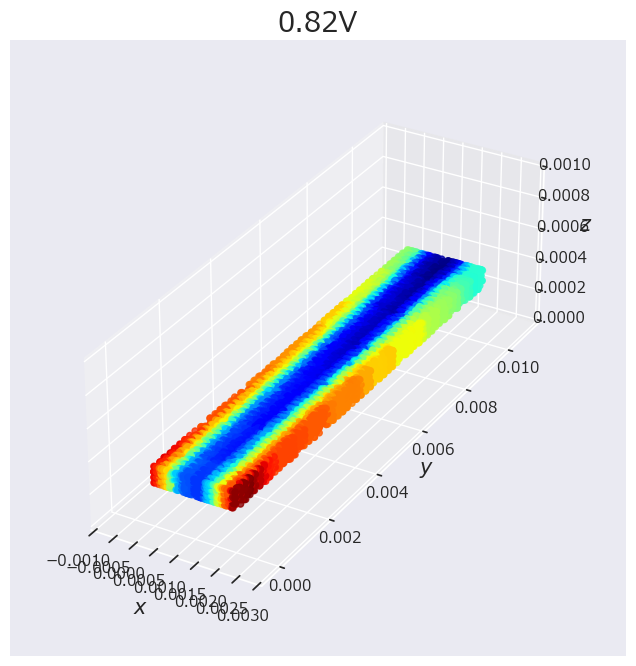

In [12]:
fig2 = plt.figure(figsize=(12, 8))
ax2 = fig2.add_subplot(111, projection='3d')

sc2 = ax2.scatter(df4['x座標'], df4['y座標'],df4['z座標'], c=df5, cmap='jet', alpha=0.8)
plt.colorbar(sc1)

ax2.set_title("0.82V", fontsize=20)
ax2.set_xlabel('$x$', fontsize=15)
ax2.set_ylabel('$y$', fontsize=15)
ax2.set_zlabel('$z$', fontsize=15)
ax2.set_box_aspect((1,3,1))

ax2.set_xlim(-0.001,0.003)
#ax2.set_ylim(0,0.015)
ax2.set_zlim(0,0.001)

#plt.savefig('PEM_CD_COMSOL.png')
plt.show()

In [13]:
df2c = df1[(df1["V"]==0.4) & (df1["T"]==100)&(df1["W"]==0.8)]
df4b = df2c.replace({'V': {0.4: 0.82}}).replace({'T': {100: 145}})
df4b
df5b = model.predict(df4b.iloc[:,1:7])

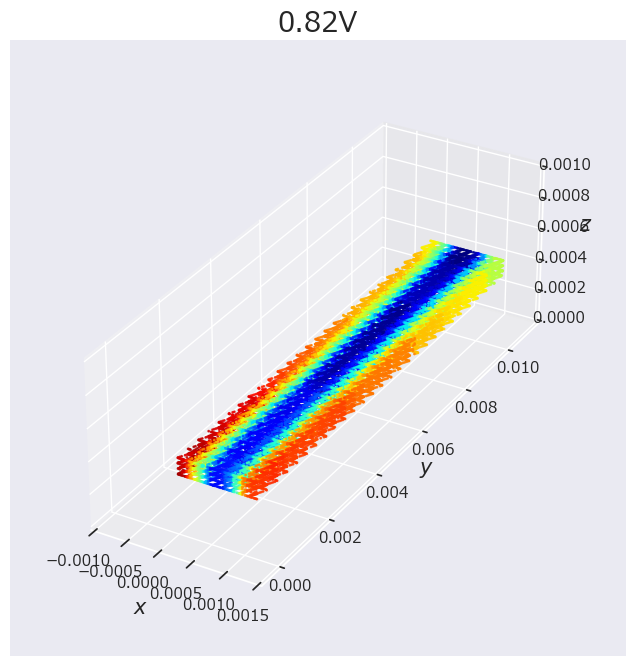

In [15]:
fig2b = plt.figure(figsize=(12, 8))
ax2b = fig2b.add_subplot(111, projection='3d')

sc2b = ax2b.scatter(df4b['x座標'], df4b['y座標'],df4b['z座標'], c=df5b, s=1, cmap='jet', alpha=0.8)
plt.colorbar(sc1)

ax2b.set_title("0.82V", fontsize=20)
ax2b.set_xlabel('$x$', fontsize=15)
ax2b.set_ylabel('$y$', fontsize=15)
ax2b.set_zlabel('$z$', fontsize=15)
ax2b.set_box_aspect((1,3,1))

ax2b.set_xlim(-0.001,0.0015)
#ax2.set_ylim(0,0.015)
ax2b.set_zlim(0,0.001)

#plt.savefig('PEM_CD_COMSOL.png')
plt.show()

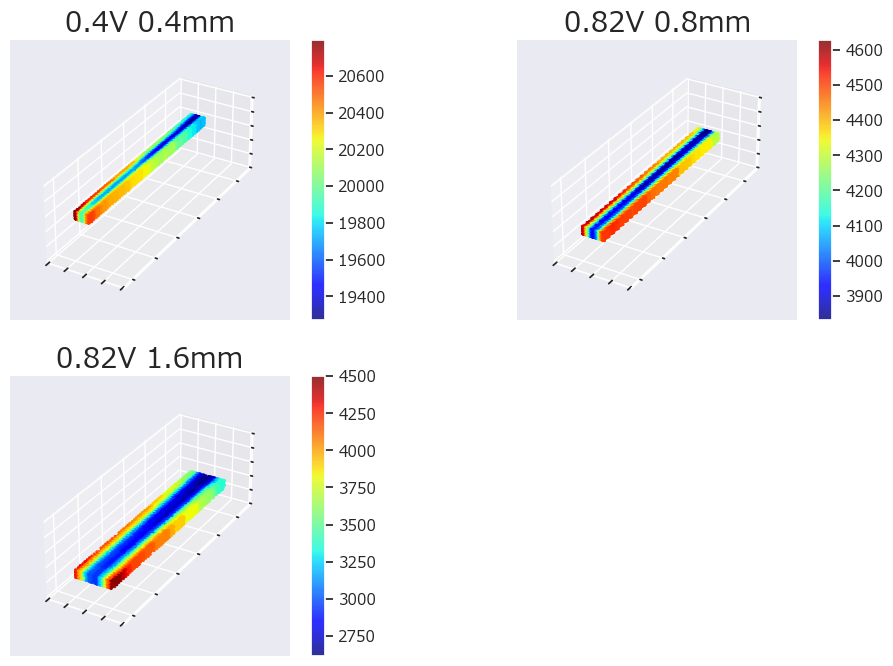

In [21]:
fig3 = plt.figure(figsize=(12, 8))

#====0.4mm====
ax1 = fig3.add_subplot(221, projection='3d')
sc1 = ax1.scatter(df2['x座標'], df2['y座標'],df2['z座標'], c=df3, s=1, cmap='jet', alpha=0.8)
plt.colorbar(sc1)

ax1.set_title("0.4V 0.4mm", fontsize=20)
ax1.set_box_aspect((1,3,1))
ax1.axes.xaxis.set_ticklabels([])
ax1.axes.yaxis.set_ticklabels([])
ax1.axes.zaxis.set_ticklabels([])
ax1.set_box_aspect((1,3,1))

ax1.set_xlim(-0.001,0.003)
#ax1.set_ylim(0,0.015)
ax1.set_zlim(0,0.001)

#====0.8mm====
ax2b = fig3.add_subplot(222, projection='3d')

sc2b = ax2b.scatter(df4b['x座標'], df4b['y座標'],df4b['z座標'], c=df5b, s=1, cmap='jet', alpha=0.8)
plt.colorbar(sc2b)

ax2b.set_title("0.82V 0.8mm", fontsize=20)
ax2b.set_box_aspect((1,3,1))
ax2b.axes.xaxis.set_ticklabels([])
ax2b.axes.yaxis.set_ticklabels([])
ax2b.axes.zaxis.set_ticklabels([])
ax2b.set_box_aspect((1,3,1))

ax2b.set_xlim(-0.001,0.003)
#ax2.set_ylim(0,0.015)
ax2b.set_zlim(0,0.001)

#====1.6mm====
ax2 = fig3.add_subplot(223, projection='3d')

sc2 = ax2.scatter(df4['x座標'], df4['y座標'],df4['z座標'], c=df5, s=1, cmap='jet', alpha=0.8)
plt.colorbar(sc2)

ax2.set_title("0.82V 1.6mm", fontsize=20)
ax2.set_box_aspect((1,3,1))
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax2.axes.zaxis.set_ticklabels([])
ax2.set_box_aspect((1,3,1))

ax2.set_xlim(-0.001,0.003)
#ax2.set_ylim(0,0.015)
ax2.set_zlim(0,0.001)

#plt.savefig('PEM_CD_COMSOL.png')
plt.show()

In [26]:
#電流密度の平均を求める関数
def I_ave(V,T,W):
    global df1
    dfA = df1[(df1['V']==0.4) & (df1['T']==100)&(df1['W']==0.4)]
    dfB = dfA.replace({'V': {0.4: V}}).replace({'T': {100: T}}).replace({'W': {0.4: W}})
    dfC = model.predict(dfB.iloc[:,1:7])
    dfD = dfC.mean()
    print(dfD)

In [27]:
I_ave(0.4,100,0.4)

19937.095987810797


In [43]:
#COMSOLの電流密度の平均表示
dfCOM = pd.DataFrame(columns=['V[V]','T_cell[℃]','W_ch[mm]','i_ave[A/m^2]'])

def I_aveCOM(V,T,W):
  global df1
  df_iaveCOM1= df1[(df1['V']==V) & (df1['T']==T)&(df1['W']==W)]
  df_iaveCOM2 = df_iaveCOM1['i[A/m^2]'].mean()
  return (df_iaveCOM2)

for V in [0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]:
  for T in [100,110,120,130,140,150]:
        for W in [0.4,0.8,1.6]:
          i_ave = I_aveCOM(V,T,W)
          new_row = {'V[V]':V,'T_cell[℃]':T,'W_ch[mm]':W,'i_ave[A/m^2]':i_ave}
          dfCOM = pd.concat([dfCOM, pd.DataFrame([new_row])], ignore_index=True)
dfCOM

C:\Users\aruhy\AppData\Local\Temp\ipykernel_22780\2395075835.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfCOM = pd.concat([dfCOM, pd.DataFrame([new_row])], ignore_index=True)


,V[V],T_cell[℃],W_ch[mm],i_ave[A/m^2]
0,0.4,100,0.4,19910.225510
1,0.4,100,0.8,17631.919163
2,0.4,100,1.6,8047.786145
3,0.4,110,0.4,21399.514452
4,0.4,110,0.8,18897.495540
...,...,...,...,...
193,0.9,140,0.8,1399.899219
194,0.9,140,1.6,1188.079213
195,0.9,150,0.4,2148.359493
196,0.9,150,0.8,2034.198423


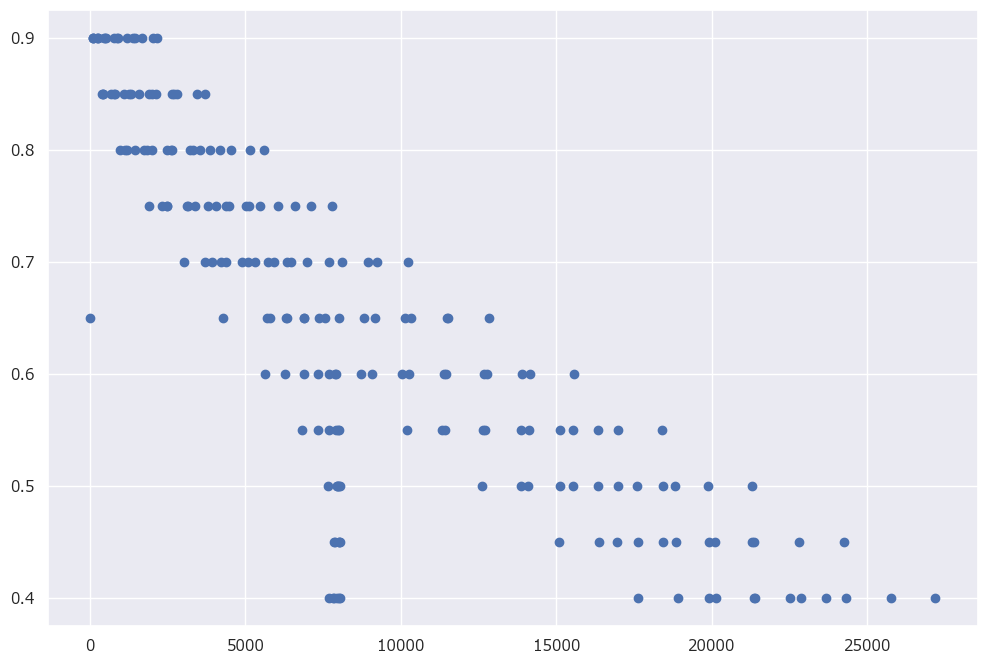

In [50]:
figCOM = plt.figure(figsize=(12, 8))

axCOM = figCOM.add_subplot(111)
scCOM = axCOM.scatter(dfCOM['i_ave[A/m^2]'],dfCOM['V[V]'])

plt.show()


In [92]:
def I_ave_pre(T,W):
 dfPRE = pd.DataFrame(columns=['V[V]','i_ave[A/m^2]'])

 global df1
 df2 = df1[(df1["V"]==0.4) & (df1["T"]==100)&(df1["W"]==W)]  #流路幅は引数で固定し、x,y,z座標を得る
 df3 = df2.replace({'T': {100: T}})    #引数Tのデータのみ抽出
 for V in np.linspace(0.4,0.9,100):   #Vの連続値に対応した電流密度を出す
    df3 = pd.DataFrame(df3)
    df4 = df3.replace({'V': {0.4: V}})
    df5 = model.predict(df4.iloc[:,1:7])    #モデルで予測
    i_ave_pre = df5.mean()        #平均値を返す
    new_row = {'V[V]':V,'i_ave[A/m^2]':i_ave_pre}
    dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力
 
 return dfPRE

In [101]:
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==120)&(dfCOM["W_ch[mm]"]==0.4)]

C:\Users\aruhy\AppData\Local\Temp\ipykernel_22780\893349272.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


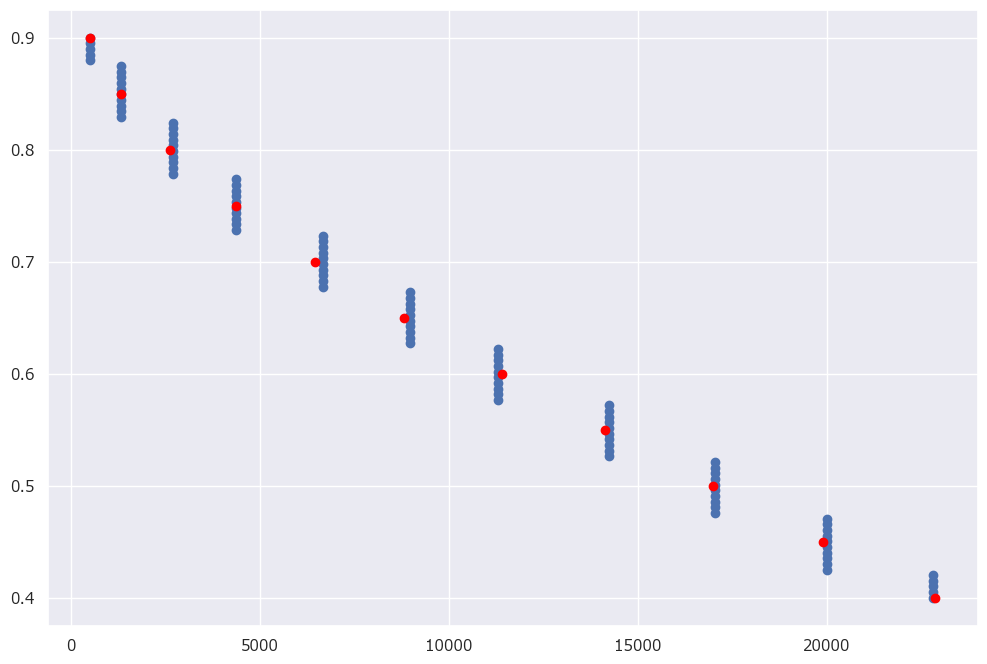

In [104]:
#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(120,0.4)
figPRE = plt.figure(figsize=(12, 8))

axPRE = figPRE.add_subplot(111)
scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]'],dfPRE['V[V]'])

#CONSOL結果の表示
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]'],dfCOM0['V[V]'],color='red')

plt.show()